# Utils

In [ ]:
import asyncio
import os
from typing import Union, List, Optional, Type
from openai import AsyncAzureOpenAI
import asyncio
import random
from typing import Union
from pydantic import BaseModel, Field


import dotenv
import pandas as pd
dotenv.load_dotenv('/Users/nadav/Desktop/GitRepos/llm/.env')

# Configuration – use environment variables or directly set values
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") or "https://your-resource-name.openai.azure.com/"
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY") or "your-azure-api-key"
AZURE_DEPLOYMENT_NAME = os.getenv("AZURE_DEPLOYMENT_NAME") or "gpt-4.1-mini"
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION") or "2023-05-15"

# Create an Azure OpenAI client
client = AsyncAzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
)


async def run_llm_call(system_prompt: str, user_prompt: str,
                       response_model: Optional[Type[BaseModel]] = None,
                       model: str = AZURE_DEPLOYMENT_NAME) -> Union[str, None]:
    max_retries = 5
    base_delay = 30  # seconds

    for attempt in range(1, max_retries + 1):
        try:
            if response_model:
                response = await client.beta.chat.completions.parse(
                    model=model,
                    messages=[
                        {"role": "system", "content": system_prompt.strip()},
                        {"role": "user", "content": user_prompt.strip()},
                    ],
                    temperature=0,
                    response_format=response_model
                )
                return response.choices[0].message.parsed
            else:
                response = await client.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": system_prompt.strip()},
                        {"role": "user", "content": user_prompt.strip()},
                    ],
                    temperature=0,
                )
                return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"Attempt {attempt} - Azure OpenAI Error: {e}")
            if attempt == max_retries:
                return None
            # Random sleep between retries
            sleep_time = base_delay * (2 ** (attempt)) + random.uniform(0, 1)
            await asyncio.sleep(sleep_time)

    

async def run_llm_calls(system_prompts: List[str], user_prompts: List[str], 
                        response_model: Optional[Type[BaseModel]] = None,
                        model: str = AZURE_DEPLOYMENT_NAME) -> List[str]:
    tasks = [
        run_llm_call(system_prompt, user_prompt, model=model, 
                     response_model=response_model)
        for system_prompt, user_prompt in zip(system_prompts, user_prompts)
    ]
    responses = await asyncio.gather(*tasks)
    return responses

Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10
Python-dotenv could not parse statement starting at line 11


# Step 1 - define evaluation criteria

In [8]:
import pandas as pd


df = pd.read_csv('datanight_workshop_data.csv')
df.head(4)

,input,information_retrieved,output,annotation,annotation_reasoning
0,What causes yellowing leaves on lemon trees?,Lemon tree's yellow leaves have owner worried\...,The yellowing of leaves on lemon trees is caus...,good,NaN
1,What are some basic tips for training a new dog?,A new dog is always an exciting addition to yo...,Some basic tips for training a new dog include...,bad,The addition of playing classical music to imp...
2,What amenities are available at the Pinnacle P...,Pinnacle Point Resort Accommodation\nPinnacle ...,The Pinnacle Point Golf Estate is located near...,bad,The output provides general information about ...
3,What are the three words that govern the creat...,Engineered to perfection\nI finally got around...,The three words that govern the creation of hu...,good,NaN


In [13]:
sys_message = """
You are an amazing data analyst analyzing user feedback provided for a question answering agent responses.
Your task is to analyze the user feedback and summarize the what are the common problemsin the agent responses.
return up to 5 common problems.
""".strip()

only_bad = df[df['annotation'] == 'bad']
responses = await run_llm_calls(
    system_prompts=[sys_message],
    user_prompts=['\n'.join(only_bad['annotation_reasoning'].tolist())],
)

print(responses[0])

Common problems identified in the agent responses based on user feedback:

1. Hallucinated Details: The agent frequently adds plausible-sounding but unsupported or incorrect information not present in the original context, leading to factual inaccuracies and potential user confusion.

2. Omissions of Crucial Information: Important details, such as names, dates, specific facts, or components of a list, are often left out, resulting in incomplete answers that reduce usefulness and clarity.

3. Contradictions with Provided Context: Some responses directly contradict key facts or statements from the source material, subtly altering meaning and potentially misleading users or QA teams.

4. Irrelevant or Off-Topic Information: Answers sometimes include general or related information that does not directly address the specific question asked, causing the response to miss the user's intent.

5. Misinterpretation or Reversal of Facts: The agent occasionally reverses positions, misattributes rol

Based on the above analysis - I would group the erros into 4 categories:
1. Incomplete
2. Irrelevant
3. Hallucinations
4. Contradictions

# Step 2 - build completeness metric

In [ ]:
df = pd.read_csv('datanight_workshop_data_w_categories.csv')
completeness_eval_df = pd.concat([df[df['curroption_category'] == 'incomplete'], df[df['annotation'] == 'good'].sample(10)])

print(completeness_eval_df.annotation.value_counts())
completeness_eval_df.head(2)

annotation
bad     10
good    10
Name: count, dtype: int64


,input,information_retrieved,output,annotation,annotation_reasoning,curroption_category
5,Who was the pitcher for the Elk River Pioneers...,The Elk River Pioneers took a 16-5 drubbing fr...,The pitcher for the Elk River Pioneers who inj...,bad,"The response omits the pitcher's name, Ben Hen...",incomplete
21,What are the components of the British Medieva...,From their website:\nBritish Medieval Lightnin...,The British Medieval Student Guide includes co...,bad,The corrupted output omits the additional read...,incomplete


In [ ]:
from enum import Enum

# Extract conclusions

system_prompt = """
You are an assistant that evaluates the completeness of answers based on a given question and context. For each answer, assign a score reflecting how fully it addresses the question using the information in the context:

0 - Not complete: The answer misses key information or fails to address some aspects of the question.

1 - Partially complete: The answer addresses all spects of the question but is incomplete.

2 - Fully complete: The answer directly and completely addresses the question, using information clearly supported by the context.

Apply logical reasoning to judge whether the answer fully satisfies the question, given the information in the context. Provide a brief explanation for the score you assign to each answer.
""".strip()


user_prompt = """
Question:
{question}

Context:
{context}

Answer:
{conclusions}
""".strip()

class ScoreValue(int, Enum):
    INCOMPLETE = 0
    PARTIALLY_COMPLETE = 1
    COMPLETE = 2

class CompletenessScore(BaseModel):
    reasoning: str
    score: ScoreValue


sys_msgs = [system_prompt] * completeness_eval_df.shape[0]
user_msgs = [
    user_prompt.format(
        question=row['input'],
        context=row['information_retrieved'],
        conclusions=row['output']
    )
    for _, row in completeness_eval_df.iterrows()
]
responses = await run_llm_calls(sys_msgs, user_msgs, response_model=CompletenessScore, model="gpt-4.1-mini")
completeness_eval_df['pred'] = [x.score / 2 for x in responses]
completeness_eval_df['pred_reasoning'] = [x.reasoning for x in responses]

print(completeness_eval_df.pred.value_counts())
completeness_eval_df.head(2)

pred
1.0    12
0.5     7
0.0     1
Name: count, dtype: int64


,input,information_retrieved,output,annotation,annotation_reasoning,curroption_category,pred,pred_reasoning,label
5,Who was the pitcher for the Elk River Pioneers...,The Elk River Pioneers took a 16-5 drubbing fr...,The pitcher for the Elk River Pioneers who inj...,bad,"The response omits the pitcher's name, Ben Hen...",incomplete,0.0,The answer identifies that the pitcher injured...,0
21,What are the components of the British Medieva...,From their website:\nBritish Medieval Lightnin...,The British Medieval Student Guide includes co...,bad,The corrupted output omits the additional read...,incomplete,0.5,"The answer mentions comprehension questions, w...",0


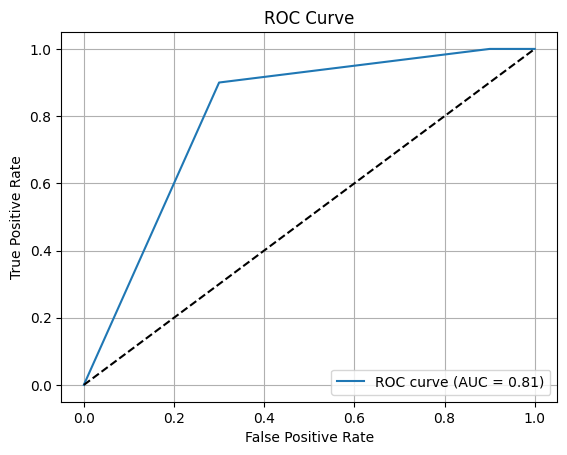

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Convert annotations to binary
completeness_eval_df['label'] = completeness_eval_df['annotation'].map({'good': 1, 'bad': 0})

# Calculate ROC AUC
roc_auc = roc_auc_score(completeness_eval_df['label'], completeness_eval_df['pred'])

# Get FPR, TPR for plotting
fpr, tpr, _ = roc_curve(completeness_eval_df['label'], completeness_eval_df['pred'])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()